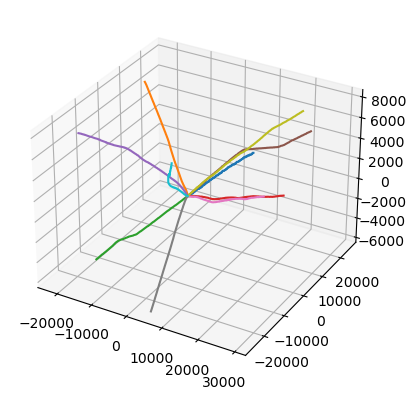

199
3
cpu
Generator Parameters: 780591
Discrminator Parameters: 92451
[0/150]: loss_d: 0.171, loss_g: 0.166
[5/150]: loss_d: 0.142, loss_g: 0.143


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [17]:
# -*- coding: utf-8 -*-
"""ecse552-cgans-actraj.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/10yNAfK3u-mp7oE8jmNk_d2ZAMgr3UaqE
"""


import torch
import torch.nn as nn
import math
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import os

def delta_maker(line):
    new_line = []
    line_dim = len(line[0])
    line_length = len(line)
    
    line = line.tolist()
    
    for i in range(0, line_dim):
        delta = []
        for j in range(0, line_length):
            if j == 0:
                prev = line[j][i]
                continue
            delta.append(line[j][i]-prev)
            prev = line[j][i]
        new_line.append(delta)
    return torch.Tensor(new_line)

def rev_delta_maker(line):
    new_line = []
    for line_dim in line:
        delta = [0]
        prev = 0
        for i, item in enumerate(line_dim):
            delta.append(float(item+prev))
            prev = item+prev
        new_line.append(delta)
    return new_line

class TrajectoryDataset(Dataset):
    def __init__(self, data_arr, label_arr, transform=None, target_transform=None):
        self.data_arr = data_arr
        self.label_arr = label_arr
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, idx):
        trajectory = self.data_arr[idx]
        label = self.label_arr[idx]
        
        trajectory = delta_maker(trajectory)

        if self.target_transform:
            label = self.target_transform(label)
        return trajectory, label

bsize = 1000
test_size = 12
dataloader = DataLoader(torch.load('/kaggle/input/dataset/dataset.pt'), batch_size=bsize, shuffle=True, drop_last=True, num_workers=5)

sample_data = next(iter(dataloader))
plt.figure(1)
ax = plt.axes(projection='3d')

for i in range(10):
    line = rev_delta_maker(sample_data[0][i])
    X, Y, Z = line[0], line[1], line[2]
    ax.plot3D(X, Y, Z)  # Plot contour curves

plt.show()

def plot_figures(generated_data, noise_labels):
    fig = plt.plot()
    ax = plt.axes(projection='3d')
    colors = ['k', 'r', 'b']
    for i, raw_data in enumerate(generated_data):
        data = raw_data.detach().tolist()
        fixed_track = rev_delta_maker(data)
        if noise_labels[i] <= 2:
            ax.plot3D(fixed_track[0],fixed_track[1],fixed_track[2], color = colors[noise_labels[i]])
            
    plt.show()

length = len(sample_data[0][0][0])
dim = len(sample_data[0][0][:,0])

print(length)
print(dim)

n_classes = 5 #Fix manually...
out_shape = (length,dim)
output_dim = length*dim

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.noise1 = nn.Sequential(
            nn.Linear(3*(dim**2), 100),
            nn.BatchNorm1d(dim),
            nn.ReLU()
        )

        self.noise2 = nn.Sequential(
            nn.Linear(100, 200),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
        )
        
        self.hidden_layer3 = nn.Sequential(
            nn.Linear(200, 880),
            nn.BatchNorm1d(dim, affine=False),
            nn.ReLU()
        )
        
        
        self.hidden_layer4 = nn.Sequential(
            nn.Linear(880, 500),
            nn.BatchNorm1d(dim, affine=False),
            nn.ReLU()
        )
        
        self.hidden_layer5 = nn.Sequential(
            nn.Linear(500, 200),
            nn.BatchNorm1d(dim, affine=False),
            nn.ReLU()
        )

        
        self.hidden_layer6 = nn.Sequential(
            nn.Linear(200, length),
            nn.BatchNorm1d(dim, affine=False),
            nn.ReLU()
        )

    def forward(self, noise):
        noise = noise.reshape(len(noise), dim, -1)
        
        n_output = self.noise1(noise)
        output = self.noise2(n_output) 
        #print("2a")       
        output = self.hidden_layer3(output)
        #print("3a")
        output = self.hidden_layer4(output)
        #print("4a")
        output = self.hidden_layer5(output)
        #print("5a")
        output = self.hidden_layer6(output)

        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(length*dim, 125),
            nn.LeakyReLU(0.05),
            nn.Dropout(0.05)
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(125, 100),
            nn.LeakyReLU(0.05),
            nn.Dropout(0.05)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(100, 50),
            nn.LeakyReLU(0.05),
            nn.Dropout(0.05)
        )

#         self.hidden_layer4 = nn.Sequential(
#             nn.Linear(100, 100),
#             nn.LeakyReLU(0.05),
#             #nn.Dropout(0.2)
#         )
        
#         self.hidden_layer5 = nn.Sequential(
#             nn.Linear(100, 50),
#             nn.LeakyReLU(0.05),
#             #nn.Dropout(0.2)
#         )
        
        self.hidden_layer6 = nn.Sequential(
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
        

    def forward(self, inp):
        inp = inp.reshape(len(inp), 1, -1)
        output = self.layer1(inp)
        output = self.hidden_layer2(output)
        #print("2")
        output = self.hidden_layer3(output)
        #print("3")
#         output = self.hidden_layer4(output)
        #print("4")
#         output = self.hidden_layer5(output)
        #print("5")
        output = self.hidden_layer6(output)
        
        output = output.squeeze(-1)
        return output.to(device)
        # Concatenate label embedding and image to produce input
        # d_in = torch.cat((inp.view(inp.size(0), -1), self.label_embedding(labels)), -1).flatten().long()
        # print(d_in.shape)
        # validity = self.model(d_in)
        # return validity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

adversarial_loss = torch.nn.MSELoss()
generator = Generator()
discriminator = Discriminator()

gen_trainable_params = sum(
    p.numel() for p in generator.parameters() if p.requires_grad
)

disc_trainable_params = sum(
    p.numel() for p in discriminator.parameters() if p.requires_grad
)
gen_txt = "Generator Parameters: {g}"
print(gen_txt.format(g = gen_trainable_params))
dis_txt = "Discrminator Parameters: {g}"
print(dis_txt.format(g = disc_trainable_params))


if str(device) == "cuda":
    print("GPU Enabled")
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5,0.999))

n_epochs = 150

FloatTensor = torch.cuda.FloatTensor if device == "cuda" else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if device == "cuda" else torch.LongTensor

for epoch_idx in range(n_epochs):
    G_loss = []
    D_loss = []
    for batch_idx, data_input in enumerate(dataloader):
        #Adversarial ground truths
        valid = torch.autograd.Variable(FloatTensor(bsize, 1).fill_(0.9), requires_grad=False).to(device)
        fake = torch.autograd.Variable(FloatTensor(bsize, 1).fill_(0.0), requires_grad=False).to(device)
        
        #Real Input
        real_tracks = data_input[0]
                
        ### Training Generator ###
        optimizer_G.zero_grad()

        noise = torch.randn((bsize, 3*dim, 3*dim)).to(device)
        generated_data = generator(noise)
        
        #Update the generator loss function based on its ability to trick
        validity = discriminator(generated_data)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()
        
        ### Training Discriminator ###
        
        mreal_track = real_tracks.to(device) 
        
        # Clear optimizer gradients        
        optimizer_D.zero_grad()
        # Forward pass with true data as input
        validity_real = discriminator(mreal_track)
        d_real_loss = adversarial_loss(validity_real, valid)
        validity_fake = discriminator(generated_data.detach())
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Average the loss
        d_loss = (
            d_real_loss + d_fake_loss
        ) / 2
        
        d_loss.backward()
        #print(d_loss)
        if d_loss.data.item()*5 > g_loss.data.item():
            optimizer_D.step()
        #optimizer_D.step()
        
        # Clear optimizer gradients

        G_loss.append(g_loss.data.item())

    if (epoch_idx)%5 == 0:
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(d_loss.to("cpu"))), torch.mean(torch.FloatTensor(g_loss.to("cpu")))))

torch.save(generator.state_dict(), "noconv_generator.h5")
torch.save(discriminator.state_dict(), "noconv_discriminator.h5")